# Notebook for preparing necessary data for COM6101 group project

## Introduction

We want to start an italian restaurant in Hong Kong. We want to find the best location for our restaurant. as well as the menu we should offer. (to be added more details)

## Data Preparation

Here are the data we need to prepare for our project:
* 2021 Hong Kong Census data (source: https://data.gov.hk/en-data/dataset/hk-censtatd-census_geo-2021-population-census-by-ssg )
* Hong Kong Restaurant License (source: https://data.gov.hk/en-data/dataset/hk-fehd-fehdlmis-restaurant-licences )
* Hong Kong Pedestrian Network (source: https://opendata.esrichina.hk/datasets/48e295256fd84032a87b27000cea35cd/about)
* Openrice data (source: https://www.openrice.com/zh/hongkong/restaurants )
* <span style="background-color: #FF0000">Hong Kong Geocommunity (source: https://data.gov.hk/en-data/dataset/hk-landsd-openmap-development-hkms-digital-geocom/resource/0931b84b-f1c8-409f-9cd4-176a26645db0 ) (May not useful, as the data cannot match the time)</span>

## Data Processing

In this notebook, we will process the data to get the following information:

### HK Census Data

In [32]:
# transform HK Census Data from espg 2326 (HK coordinate system) to 4326 (WGS84)
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon

gpdf = 'data/2021_census/LSUG_21C.json'

class transform_LSUG:
    def __init__(self, gpdf, epsg=2326, output_path='data/2021_census'):
        self.output_path = output_path
        self.gpdf = gpd.read_file(gpdf)
        self.epsg = epsg
    def transform(self):
        self.gpdf = self.gpdf.set_crs(epsg=self.epsg, allow_override=True)
        self.gpdf = self.gpdf.to_crs(epsg=4326)
        self.gpdf['name'] = self.gpdf.index
        self.gpdf = self.gpdf.explode()
        self.gpdf['geometry'] = self.gpdf['geometry'].apply(lambda x: Polygon(x.exterior.coords))
        return self.gpdf
    def export(self):
        self.transform()
        return self.gpdf.to_file(self.output_path + '/LSUG_21C_lat_lng.json', driver='GeoJSON')

transform_LSUG(gpdf).export()

C:\Users\kwokt\AppData\Local\Temp\ipykernel_25024\2574490307.py:17: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  self.gpdf = self.gpdf.explode()


Transform the HK Census data to preferred attributes:

In [33]:
import geopandas as gpd

LSUG = gpd.read_file('data/2021_census/LSUG_21C_lat_lng.json')
LSUG_copy = LSUG.copy()
LSUG_copy

,level_0,level_1,age_1,age_2,age_3,age_4,age_5,born_chi,born_else,born_hk,...,wp_n,wp_o,wp_p,wp_q,wp_r,wp_s,wp_se,wp_t,name,geometry
0,0,0,257,141,472,461,224,259,362,934,...,-,91,63,154,123,141,130,-,0,"POLYGON ((114.12554 22.28403, 114.12554 22.284..."
1,0,1,257,141,472,461,224,259,362,934,...,-,91,63,154,123,141,130,-,0,"POLYGON ((114.11267 22.28621, 114.11267 22.286..."
2,0,2,257,141,472,461,224,259,362,934,...,-,91,63,154,123,141,130,-,0,"POLYGON ((114.11683 22.28633, 114.11683 22.286..."
3,1,0,199,42,527,510,253,321,290,920,...,11,56,284,199,135,153,47,-,1,"POLYGON ((114.12668 22.28306, 114.12654 22.283..."
4,2,0,276,163,760,664,146,470,278,1261,...,62,36,250,187,203,101,50,25,2,"POLYGON ((114.12804 22.28329, 114.12791 22.283..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,1743,0,153,159,689,686,339,400,108,1518,...,16,56,53,227,340,158,82,14,1743,"POLYGON ((114.04878 22.28376, 114.04878 22.283..."
1963,1743,1,153,159,689,686,339,400,108,1518,...,16,56,53,227,340,158,82,14,1743,"POLYGON ((114.04416 22.28705, 114.04416 22.287..."
1964,1744,0,102,157,636,748,440,343,118,1622,...,45,22,90,284,186,109,131,31,1744,"POLYGON ((114.03342 22.29006, 114.03335 22.290..."
1965,1744,1,102,157,636,748,440,343,118,1622,...,45,22,90,284,186,109,131,31,1744,"POLYGON ((114.04349 22.29217, 114.04346 22.292..."


In [34]:
'''
calculate the mean of age in each subnit group
age_1 represents number of people in age 0-14, age_2 represents number of people in age 15-24,
age_3 represents number of people in age 25-44, age_4 represents number of people in age 45 - 64
age_5 represents number of people in age 65 or above, assume it is 65-84
Method of finding the mean of age in each subunit group:
1. multiply the number of people in each age group by the middle value of the age group
2. sum up the result of each age group
3. divide the sum by the total number of people in the subunit group
'''
# input all '-' to 0 first
LSUG_copy[['age_1', 'age_2', 'age_3', 'age_4', 'age_5']] = LSUG_copy[['age_1', 'age_2', 'age_3', 'age_4', 'age_5']].replace('-', '0')

# change dtype from int to float
LSUG_copy[['age_1', 'age_2', 'age_3', 'age_4', 'age_5']] = LSUG_copy[['age_1', 'age_2', 'age_3', 'age_4', 'age_5']].astype('float')

LSUG_copy['mean_age'] = LSUG_copy['age_1'] * 7 + LSUG_copy['age_2'] * 19.5 + LSUG_copy['age_3'] * 34.5 + LSUG_copy['age_4'] * 54.5 + LSUG_copy['age_5'] * 74.5
# median age is the age of the middle person in the subunit group, find the median age of each subunit group first by dividing the total number of people in the subunit group by 2
LSUG_copy['median_age'] = (LSUG_copy['age_1'] + LSUG_copy['age_2'] + LSUG_copy['age_3'] + LSUG_copy['age_4'] + LSUG_copy['age_5']) / 2
LSUG_copy['median_age'] = LSUG_copy['median_age'].astype('int')

# look the median is situated in which age group, then find the middle value of the age group
LSUG_copy.loc[LSUG_copy['median_age'] <= LSUG_copy['age_1'], 'median_age'] = 7 # age_1
LSUG_copy.loc[(LSUG_copy['median_age'] > LSUG_copy['age_1']) & (LSUG_copy['median_age'] <= LSUG_copy['age_1'] + LSUG_copy['age_2']), 'median_age'] = 20 # age_2
LSUG_copy.loc[(LSUG_copy['median_age'] > LSUG_copy['age_1'] + LSUG_copy['age_2']) & (LSUG_copy['median_age'] <= LSUG_copy['age_1'] + LSUG_copy['age_2'] + LSUG_copy['age_3']), 'median_age'] = 35 # age_3
LSUG_copy.loc[(LSUG_copy['median_age'] > LSUG_copy['age_1'] + LSUG_copy['age_2'] + LSUG_copy['age_3']) & (LSUG_copy['median_age'] <= LSUG_copy['age_1'] + LSUG_copy['age_2'] + LSUG_copy['age_3'] + LSUG_copy['age_4']), 'median_age'] = 55 # age_4
LSUG_copy.loc[(LSUG_copy['median_age'] > LSUG_copy['age_1'] + LSUG_copy['age_2'] + LSUG_copy['age_3'] + LSUG_copy['age_4']) & (LSUG_copy['median_age'] <= LSUG_copy['age_1'] + LSUG_copy['age_2'] + LSUG_copy['age_3'] + LSUG_copy['age_4'] + LSUG_copy['age_5']), 'median_age'] = 75 # age_5

LSUG_copy['mean_age'] = LSUG_copy['mean_age'] / (LSUG_copy['age_1'] + LSUG_copy['age_2'] + LSUG_copy['age_3'] + LSUG_copy['age_4'] + LSUG_copy['age_5'])

# reduce the effect of outliers of mean age
LSUG_copy['mean_median_age'] = LSUG_copy['mean_age'] * 0.5 + LSUG_copy['median_age'] * 0.5
LSUG_copy[['mean_age', 'median_age', 'mean_median_age']].describe()

,mean_age,median_age,mean_median_age
count,1967.000000,1967.000000,1967.000000
mean,43.942314,45.810880,44.876597
std,3.833918,10.043943,6.564367
min,29.875228,20.000000,24.937614
25%,41.319854,35.000000,38.249683
50%,43.811919,55.000000,48.813066
75%,46.581901,55.000000,50.781901
max,65.826733,75.000000,70.413366


In [35]:
# total population is the sum of age_1, age_2, age_3, age_4, age_5
LSUG_copy['total_population'] = LSUG_copy['age_1'] + LSUG_copy['age_2'] + LSUG_copy['age_3'] + LSUG_copy['age_4'] + LSUG_copy['age_5']
LSUG_copy['total_population'].describe()

count     1967.000000
mean      4083.156075
std       4687.779911
min       1000.000000
25%       1595.500000
50%       2208.000000
75%       4311.500000
max      39767.000000
Name: total_population, dtype: float64

In [36]:
# median of income is in ma_hh
LSUG_copy['median_hs_income'] = LSUG_copy['ma_hh']
LSUG_copy['median_hs_income'].value_counts()

median_hs_income
63820    57
47850    43
17000    28
47070    19
20040    17
         ..
40560     1
86240     1
89870     1
62140     1
82290     1
Name: count, Length: 1286, dtype: int64

In [37]:
# mean household size: total_population / dh
# convert dh '-' to 1
LSUG_copy['dh'] = LSUG_copy['dh'].replace('-', '1')
LSUG_copy['dh'] = LSUG_copy['dh'].astype('float')
LSUG_copy['mean_hs_size'] = LSUG_copy['total_population'] / LSUG_copy['dh']
# for rows where 'dh' = 1, set mean_hs_size = 1
LSUG_copy.loc[LSUG_copy['dh'] == 1, 'mean_hs_size'] = 1
# find row where 'mean_hs_size' > 10, set mean_hs_size = 10
LSUG_copy.loc[LSUG_copy['mean_hs_size'] > 10, 'mean_hs_size'] = 10
LSUG_copy['mean_hs_size'].describe()

count    1967.000000
mean        2.854699
std         0.592379
min         1.000000
25%         2.484750
50%         2.782135
75%         3.095936
max        10.000000
Name: mean_hs_size, dtype: float64

In [38]:
# % in labour force: t_wp / total_population
# transform '-' to 0
LSUG_copy['t_wp'] = LSUG_copy['t_wp'].replace('-', '0')
# transform dtype from str to float
LSUG_copy['t_wp'] = LSUG_copy['t_wp'].astype('float')
LSUG_copy['labour_force_percent'] = LSUG_copy['t_wp'] / LSUG_copy['total_population']
LSUG_copy['labour_force_percent'].describe()

count    1967.000000
mean        0.510765
std         0.067052
min         0.000000
25%         0.471007
50%         0.515250
75%         0.555184
max         0.785621
Name: labour_force_percent, dtype: float64

In [39]:
# % of Chinese: ethn_chi / total_population
# transform '-' to 0
LSUG_copy['ethn_chi'] = LSUG_copy['ethn_chi'].replace('-', '0')
# transform dtype from str to float
LSUG_copy['ethn_chi'] = LSUG_copy['ethn_chi'].astype('float')
LSUG_copy['chinese_percent'] = LSUG_copy['ethn_chi'] / LSUG_copy['total_population']
LSUG_copy['chinese_percent'].describe()

count    1967.000000
mean        0.863458
std         0.133182
min         0.263777
25%         0.817618
50%         0.915462
75%         0.955576
max         1.000000
Name: chinese_percent, dtype: float64

In [40]:
# % of Male: pop_m / total_population
# transform '-' to 0
LSUG_copy['pop_m'] = LSUG_copy['pop_m'].replace('-', '0')
# transform dtype from str to float
LSUG_copy['pop_m'] = LSUG_copy['pop_m'].astype('float')
LSUG_copy['pop_m_percent'] = LSUG_copy['pop_m'] / LSUG_copy['total_population']
LSUG_copy['pop_m_percent'].describe()

count    1967.000000
mean        0.452532
std         0.044367
min         0.298851
25%         0.428301
50%         0.454599
75%         0.476916
max         0.888457
Name: pop_m_percent, dtype: float64

In [41]:
# % of owner owned property: ten_oc / LSUG_copy['dh']
# transform '-' to 0
LSUG_copy['ten_oc'] = LSUG_copy['ten_oc'].replace('-', '0')
# transform dtype from str to float
LSUG_copy['ten_oc'] = LSUG_copy['ten_oc'].astype('float')
LSUG_copy['ten_oc_percent'] = LSUG_copy['ten_oc'] / LSUG_copy['dh']
LSUG_copy['ten_oc_percent'].describe()

count    1967.000000
mean        0.532857
std         0.246771
min         0.000000
25%         0.410584
50%         0.550868
75%         0.721917
max         1.000000
Name: ten_oc_percent, dtype: float64

In [42]:
# rent to income ratio: dmr_ir
# transform from object to float
import pandas as pd
LSUG_copy['rent_to_income_ratio'] = pd.to_numeric(LSUG_copy['dmr_ir'], errors='coerce')
LSUG_copy.loc[(LSUG_copy['rent_to_income_ratio'] > 100), 'rent_to_income_ratio'] = 100
LSUG_copy['rent_to_income_ratio'] = LSUG_copy['rent_to_income_ratio'] / 100
LSUG_copy['rent_to_income_ratio'].describe()

count    1900.000000
mean        0.283352
std         0.117332
min         0.020000
25%         0.219000
50%         0.289000
75%         0.346000
max         1.000000
Name: rent_to_income_ratio, dtype: float64

In [50]:
# export used columns to json file, rename 'name' to 'census_subnit' first
LSUG_copy = LSUG_copy.rename(columns={'name': 'census_subnit'})
# used columns: 'subunit', 'mean_median_age', 'median_hs_income', 'mean_hs_size', 'labour_force_percent', 'chinese_percent', 'pop_m_percent', 'ten_oc_percent', 'rent_to_income_ratio', 'geometry'
LSUG_copy[['census_subnit', 'mean_median_age', 'median_hs_income', 'mean_hs_size', 'labour_force_percent', 'chinese_percent', 'pop_m_percent', 'ten_oc_percent', 'rent_to_income_ratio', 'geometry']].to_file('data/2021_census/LSUG_21C_cleaned.json', driver='GeoJSON')

In [51]:
# preview the cleaned data
LSUG_copy[['census_subnit', 'mean_median_age', 'median_hs_income', 'mean_hs_size', 'labour_force_percent', 'chinese_percent', 'pop_m_percent', 'ten_oc_percent', 'rent_to_income_ratio', 'geometry']].head()

,census_subnit,mean_median_age,median_hs_income,mean_hs_size,labour_force_percent,chinese_percent,pop_m_percent,ten_oc_percent,rent_to_income_ratio,geometry
0,0,37.643087,51370,3.031189,0.506109,0.779421,0.518971,0.670565,0.273,"POLYGON ((114.12554 22.28403, 114.12554 22.284..."
1,0,37.643087,51370,3.031189,0.506109,0.779421,0.518971,0.670565,0.273,"POLYGON ((114.11267 22.28621, 114.11267 22.286..."
2,0,37.643087,51370,3.031189,0.506109,0.779421,0.518971,0.670565,0.273,"POLYGON ((114.11683 22.28633, 114.11683 22.286..."
3,1,39.393207,55680,2.244868,0.640758,0.835402,0.430438,0.478006,0.295,"POLYGON ((114.12668 22.28306, 114.12654 22.283..."
4,2,37.011075,50040,2.272624,0.578895,0.837730,0.446491,0.573529,0.252,"POLYGON ((114.12804 22.28329, 114.12791 22.283..."


### Restaurant License Data

In [44]:
# transfer xml to csv for restaurant licence data
import os
import xml.etree.ElementTree as Xet
import pandas as pd

folder_path = 'data/restaurant_license/xml'
output_folder = 'data/restaurant_license/csv'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

cols = ["TYPE", "DIST", "LICNO", "SS", "ADR", "INFO", "EXPDATE"]

# Iterate through all XML files in the folder_path
for filename in os.listdir(folder_path):
    if filename.endswith(".XML"):
        xml_file = os.path.join(folder_path, filename)
        csv_file = os.path.join(output_folder, os.path.splitext(filename)[0][1:] + ".csv")
        rows = []
        xmlparse = Xet.parse(xml_file)
        # The data are stored in the <LPS> tag
        root = xmlparse.getroot().find("LPS")

        for i in root:
            
            TYPE = i.find("TYPE").text
            DIST = i.find("DIST").text
            LICNO = i.find("LICNO").text
            SS = i.find("SS").text
            ADR = i.find("ADR").text
            INFO = i.find("INFO").text
            EXPDATE = i.find("EXPDATE").text
            rows.append({"TYPE": TYPE, "DIST": DIST, "LICNO": LICNO, 
                         "SS": SS, "ADR": ADR, "INFO": INFO, "EXPDATE": EXPDATE})

        df = pd.DataFrame(rows, columns=cols)
        df.to_csv(csv_file, index=False)
        print(f"Converted {filename} to {os.path.splitext(filename)[0][1:] + '.csv'}")

print("XML to CSV conversion completed.")

Converted 20230101-1033-LP_Restaurants_EN.XML to 0230101-1033-LP_Restaurants_EN.csv
Converted 20240101-1050-LP_Restaurants_EN.XML to 0240101-1050-LP_Restaurants_EN.csv
XML to CSV conversion completed.


In [46]:
# geocoding for restaurant licence data
import os
import pandas as pd
import geocoder

API_KEY = "AAPK3ac33a03387e472db4ac246ec302438c69Oee1EeJzIYy8Qlsbogx5ZziXUuE247Xeb2ASN4douVyGLHZ9MwCGHEtPdJPJz8"

folder_path = 'data/restaurant_license/csv'
output_folder = 'data/restaurant_license/geo'

# create output folder if not exist
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

# Iterate through all CSV files in the folder_path
# columns: TYPE, DIST, LICNO, SS, ADR, INFO, EXPDATE
# column ADR is the address

# use old csv file to reference if address already exist
old_file = 'data/restaurant_license/geo/geo_full.csv'

for filename in os.listdir(folder_path):
    # only retrive csv file and file not end with .finished.csv
    if filename.endswith(".csv") and not filename.endswith(".finished.csv"):
        print(f'start converting {filename} to geo location')
        csv_file = os.path.join(folder_path, filename)
        geo_file = os.path.join(output_folder, filename + ".geo.csv")
        # find rows if ADR contains ['KWAI CHUNG"] or ['TSUEN WAN']
        # transform ADR to upper case first
        df = pd.read_csv(csv_file, encoding='utf-8')
        df['ADR'] = df['ADR'].str.upper()
        df = df.loc[lambda df: df['ADR'].str.contains('KWAI CHUNG') | df['ADR'].str.contains('TSUEN WAN')]
        # add new columns for geo location
        lat = []
        lng = []
        df.reset_index(inplace=True, drop=True)
        # check if df['ADR'] == old_df['ADR']
        old_df = pd.read_csv(old_file, encoding='utf-8')
        for i in range(len(df)):
            if df['ADR'][i] in old_df['ADR'].values:
                # if address already exist in old_df, then use the geo location in old_df
                lat.append(old_df.loc[old_df['ADR'] == df['ADR'][i], 'lat'].iloc[0])
                lng.append(old_df.loc[old_df['ADR'] == df['ADR'][i], 'lng'].iloc[0])
                print(f"Converted {df['ADR'][i]} to {old_df.loc[old_df['ADR'] == df['ADR'][i], 'lat'].iloc[0]}, {old_df.loc[old_df['ADR'] == df['ADR'][i], 'lng'].iloc[0]}, by referencing old csv file")
                continue
            g = geocoder.arcgis(df['ADR'][i], key = API_KEY)
            lat.append(g.lat)
            lng.append(g.lng)
            print(f"Converted {df['ADR'][i]} to {g.lat}, {g.lng}")
        df['lat'] = lat
        df['lng'] = lng
        df.to_csv(geo_file, index=False)
        # rename the original csv file to finished
        os.rename(csv_file, os.path.join(folder_path, filename + "_finished.csv"))
        print(f"Converted {filename} to {filename}")
print("All csv files converted to geo location")

start converting 0230101-1033-LP_Restaurants_EN.csv to geo location
Converted 290, G/F., 290-292, M/F, SHA TSUI ROAD, TSUEN WAN, NEW TERRITORIES to 22.36932735534819, 114.117078387233, by referencing old csv file
Converted 15-16, WING KA HOUSE, FUK LOI ESTATE, G/F., TSUEN WAN, NEW TERRITORIES to 22.373866994108013, 114.1124345614167, by referencing old csv file
Converted NO. 9 SAN TSUEN MAIN STREET, G/F & 1/F, SHAM TSENG, TSUEN WAN, NEW TERRITORIES to 22.353245961644333, 114.10051331580638, by referencing old csv file
Converted 13 MAIN STREET, SAN TSUEN, SHAM TSENG, TSUEN WAN, NEW TERRITORIES to 22.37008224800008, 114.05948684100008, by referencing old csv file
Converted YUEN YUEN INSTITUTE, LO WAI, TSUEN WAN, NEW TERRITORIES to 22.383020000000045, 114.12272000000009, by referencing old csv file
Converted NO. 12-14 HOI PA STREET, G/F, TSUEN WAN, NEW TERRITORIES to 22.3738310357434, 114.11179569275669, by referencing old csv file
Converted NO. 294 SHA TSUI ROAD, G/F & M/F, TSUEN WAN, NE

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data/restaurant_license/csv\\0230101-1033-LP_Restaurants_EN.csv' -> 'data/restaurant_license/csv\\0230101-1033-LP_Restaurants_EN.csv_finished.csv'

In [ ]:
# map the restaurant licence data to its relative HK census polygon TPU
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import os

class map_census_polygon_restaurant:
    def __init__(self, census_polygon, restaurant_path, output_folder, restaurant_name):
        self.census_polygon = gpd.read_file(census_polygon)
        self.restaurant_path = restaurant_path
        self.restaurant_name = restaurant_name
        self.output_folder = output_folder
    def map(self):
        restaurant = pd.read_csv(self.restaurant_path + self.restaurant_name)
        # if restaurant['lat'] and restaurant['lng'] are contained in census_polygon['geometry'], then the restaurant is in the census polygon
        try:
            restaurant['census_subnit'] = restaurant.apply(lambda row: self.census_polygon[self.census_polygon['geometry'].contains(Point(row['lng'], row['lat']))]['name'].values[0], axis=1) 
        except:
            restaurant['census_subnit'] = restaurant.apply(lambda row: self.census_polygon[self.census_polygon['geometry'].contains(Point(row['lng'], row['lat']))]['name'].values, axis=1)
        # if restaurant['census_subnit'] is a list, then only keep the first element
        restaurant['census_subnit'] = restaurant['census_subnit'].str[0]
        # export the mapped restaurant to csv, named as the file name of the original restaurant csv file to output_folder
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder, exist_ok=True)
        return restaurant.to_csv(self.output_folder + self.restaurant_name.replace('.csv.geo.csv', '') + '_geo_mapped.csv', index=False), print(f"Restaurant {self.restaurant_name} mapped to census polygon")
    
# loop all the restaurant csv files in folder restaurant-info-hk/geo, and map them to census polygon
census_polygon = 'data/2021_census/LSUG_21C_lat_lng.json'
restaurant_path = 'data/restaurant_license/geo/'
output_folder = 'data/restaurant_license/geo_mapped/'
for restaurant_name in os.listdir(restaurant_path):
    map_census_polygon_restaurant(census_polygon, restaurant_path, output_folder, restaurant_name).map()

Restaurant 0230101-1033-LP_Restaurants_EN.csv.geo.csv mapped to census polygon
Restaurant geo_full.csv mapped to census polygon
Restaurant 0240101-1050-LP_Restaurants_EN.csv.geo.csv mapped to census polygon


In [49]:
# preview the mapped restaurant data
restaurant_mapped = pd.read_csv('data/restaurant_license/geo_mapped/0230101-1033-LP_Restaurants_EN_geo_mapped.csv')
restaurant_mapped.head()

,TYPE,DIST,LICNO,SS,ADR,INFO,EXPDATE,lat,lng,census_subnit
0,RL,92,2292000010,東江,"290, G/F., 290-292, M/F, SHA TSUI ROAD, TSUEN ...",NaN,2023-06-30,22.369327,114.117078,1006.0
1,RL,92,2292000047,海蓮,"15-16, WING KA HOUSE, FUK LOI ESTATE, G/F., TS...",NaN,2023-06-30,22.373867,114.112435,989.0
2,RL,92,2292000056,裕記,"NO. 9 SAN TSUEN MAIN STREET, G/F & 1/F, SHAM T...",NaN,2023-06-30,22.353246,114.100513,1072.0
3,RL,92,2292000065,能記飯店,"13 MAIN STREET, SAN TSUEN, SHAM TSENG, TSUEN W...",NaN,2023-06-30,22.370082,114.059487,1061.0
4,RL,92,2292000074,圓玄學院,"YUEN YUEN INSTITUTE, LO WAI, TSUEN WAN, NEW TE...",NaN,2023-06-30,22.383020,114.122720,973.0


### Pedestrian Network Data

Measuring the pedestrian accessibility of each restaurant location

In [57]:
# import json data for pedestrian network
# reference: https://towardsdatascience.com/measuring-pedestrian-accessibility-97900f9e4d56
import geopandas as gpd
import osmnx as ox

pedestrian_network = gpd.read_file('data/pedestrian_network/PedestrianRoute.json')
pedestrian_network.head()

,OBJECTID,PedestrianRouteID,Location,FeatureType,AliasNameEN,AliasNameTC,CrossingFeature,WeatherProof,WheelchairBarrier,WheelchairAccess,...,BuildingID_1,BuildingID_2,SiteID,TerminalID,AccessTimeID,CreationDate,ModifiedBy,LastAmendmentDate,Shape_Length,geometry
0,1,250000001,Outdoor,Footway,"Praya, Kennedy Town",堅彌地城海旁,None,NonCovered,False,False,...,NaN,NaN,NaN,NaN,NaN,20210228,LANDSD,20230207,34.430755,"LINESTRING Z (831496.959 816203.397 3.598, 831..."
1,2,250000005,Outdoor,Generalized Walkway inside Park,Belcher Bay Park,卑路乍灣公園,None,NonCovered,False,False,...,NaN,NaN,1.503015e+09,NaN,NaN,20210228,LANDSD,20230207,34.413483,"LINESTRING Z (831501.427 816287.739 4.716, 831..."
2,3,250000007,Outdoor,Footway,Belcher Bay Park,卑路乍灣公園,None,NonCovered,False,False,...,NaN,NaN,1.503015e+09,NaN,NaN,20210228,LANDSD,20230207,14.732824,"LINESTRING Z (831468.627 816191.791 3.892, 831..."
3,4,250000012,Outdoor,Footway,Shing Sai Road,城西道,None,NonCovered,False,False,...,NaN,NaN,NaN,NaN,NaN,20210228,LANDSD,20230427,9.429937,"LINESTRING Z (831497.314 816356.602 5.231, 831..."
4,5,250000020,Outdoor,Generalized Walkway inside Park,Belcher Bay Park,卑路乍灣公園,None,NonCovered,False,False,...,NaN,NaN,1.503015e+09,NaN,NaN,20210228,LANDSD,20230207,25.143948,"LINESTRING Z (831507.344 816252.361 3.899, 831..."


<Axes: >

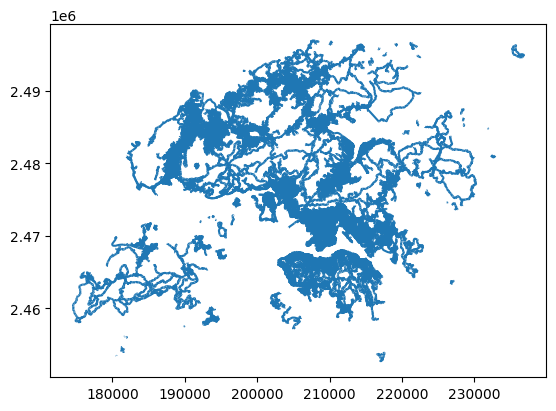

In [58]:
# preview the pedestrian network data
g = ox.project_gdf(pedestrian_network)
g.plot()

In [67]:
# compute distance from each restaurant to the nearest pedestrian network
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import osmnx as ox

class distance_to_pedestrian_network:
    def __init__(self, pedestrian_network, restaurant_path, output_folder):
        self.pedestrian_network = pedestrian_network
        self.restaurant_path = restaurant_path
        self.restaurant_name = restaurant_name
        self.output_folder = output_folder
    def compute(self):
        restaurant = pd.read_csv(self.restaurant_path)
        # convert restaurant to geodataframe
        restaurant['geometry'] = [Point(xy) for xy in zip(restaurant['lng'], restaurant['lat'])]
        restaurant = gpd.GeoDataFrame(restaurant, geometry='geometry')
        # compute shortest distance from each restaurant to the nearest pedestrian network
        restaurant['distance_to_pedestrian'] = restaurant['geometry'].apply(lambda x: self.pedestrian_network.distance(x).min())
        # export the distance to pedestrian network to csv, named as the file name of the original restaurant csv file to output_folder
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder, exist_ok=True)
        return restaurant.to_csv(self.output_folder + self.restaurant_name + '_pedestrian.csv', index=False), print(f"Restaurant {self.restaurant_name} distance to pedestrian network computed")
    
# loop all the restaurant csv files in folder restaurant-info-hk/geo_mapped, and compute the distance to the nearest pedestrian network
restaurant_path = 'data/restaurant_license/geo_mapped_test/'
output_folder = 'data/restaurant_license/geo_mapped_test/'

for restaurant_name in os.listdir(restaurant_path):
    distance_to_pedestrian_network(pedestrian_network, restaurant_path + restaurant_name, output_folder).compute()


C:\Users\kwokt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


Restaurant Trial.csv distance to pedestrian network computed


In [68]:
# plot the restaurant on the map with pedestrian network, to see if the distance is computed correctly
restaurant = pd.read_csv('data/restaurant_license/geo_mapped_test/Trial.csv_pedestrian.csv')

# convert restaurant to geodataframe
restaurant['geometry'] = [Point(xy) for xy in zip(restaurant['lng'], restaurant['lat'])]
restaurant = gpd.GeoDataFrame(restaurant, geometry='geometry')

# plot the pedestrian network and the restaurant
g = ox.project_gdf(pedestrian_network)
g.plot()
restaurant.plot(ax=g, color='red')